In [1]:
import requests
import torch
import torch.nn.functional as F
from PIL import Image
from transformers import AutoProcessor, AutoModelForVision2Seq, Idefics2Processor, Idefics2Model
from transformers.image_utils import load_image
import matplotlib.pyplot as plt
import decord
import numpy as np
import os
import re

In [2]:
video_path = "/home/levi/data/dev_videos/"
# Get all the video files with the regex pattern
franca_cabinet_video_files = [f for f in os.listdir(video_path) if re.match(r'franka_cabinet_video.*\_1.mp4', f)]
# Sort the video files
franca_cabinet_video_files.sort()

In [3]:
def get_video_frames(video_path: str, num_frames: int=32, start_frame: int=-1, end_frame: int=-1):
    # Load the video
    vr = decord.VideoReader(video_path)
    if start_frame == -1:
        start_frame = 0
    if end_frame == -1:
        end_frame = len(vr)
    segment_frame_count = end_frame - start_frame
    frame_delta = segment_frame_count // num_frames
    # get the first num_frames frame indices from the segment
    frame_idx = [start_frame+i*frame_delta for i in range(num_frames)]
    # if frame_idx has more elements than num_frames, remove the last element
    if len(frame_idx) > num_frames:
        frame_idx = frame_idx[:-1]       
    
    frames = torch.tensor(vr.get_batch(frame_idx).asnumpy(), dtype=torch.float32)
    return frames

In [4]:
# Idefics2 processor and model
processor = Idefics2Processor.from_pretrained("HuggingFaceM4/idefics2-8b", do_image_splitting=False)
model = Idefics2Model.from_pretrained(
    "HuggingFaceM4/idefics2-8b",
    torch_dtype=torch.bfloat16
).cuda()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [36]:
def compute_idefics2_score(video_frames, caption, model, processor):

    # Encode the text
    message = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": f"{caption}"},
        ]
        },
    ]   
    prompt = processor.apply_chat_template(message, add_generation_prompt=False)
    model = model.cuda()

    score = 0
    scores = []
    for i, image1 in enumerate(video_frames):
        image1 = Image.fromarray(image1.numpy().astype(np.uint8))
        inputs = processor(text=prompt, images=[image1], return_tensors="pt")
        inputs = {k: v.cuda() for k, v in inputs.items()}

        model.eval()
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

        

        all_embeddings = outputs.last_hidden_state

        image_token_indices = inputs["input_ids"].eq(32001).nonzero(as_tuple=True)[1]
        text_token_indices = torch.arange(image_token_indices[-1] + 2, inputs["input_ids"].shape[1] - 3)

        image_embeddings = all_embeddings[0, image_token_indices]
        text_embeddings = all_embeddings[0, text_token_indices]

        # Normalize the embeddings to unit vectors
        # text_emb_normalized = F.normalize(text_embeddings, p=2, dim=1)
        # image_emb_normalized = F.normalize(image_embeddings, p=2, dim=1)   


        # comput the mean text embedding 
        # mean_text_embedding = text_emb_normalized.mean(dim=0).unsqueeze(0)

        # # compute the mean image embedding
        # mean_image_embedding = image_emb_normalized.mean(dim=0).unsqueeze(0)

        mean_text_embedding = text_embeddings.mean(dim=0).unsqueeze(0)
        mean_image_embedding = image_embeddings.mean(dim=0).unsqueeze(0)

        # compute the cosine similarity between the average text and image embeddings
        # cos_sim = F.cosine_similarity(mean_text_embedding, mean_image_embedding) 
        # store the max between the old score and the new score
        # compute the euclidean distance between the average text and image embeddings
        d = F.pairwise_distance(mean_text_embedding, mean_image_embedding).item()
        #sim = torch.exp(-d).item()
        score += d
        #score += cos_sim.item()
        #scores.append(cos_sim.item())
        scores.append(d)
    return score, scores, image_embeddings, text_embeddings
    

In [25]:
def compute_idefics2_baseline_score(video_frames, caption, base_caption, model, processor):

# This code assumes the baseline frame is the first frame in the video_frames list

    
    
    model = model.cuda()

    score = 0
    scores = []
    for i, image1 in enumerate(video_frames):

        if i == 0:
            caption = base_caption

        # Encode the text
        message = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": f"{caption}"},
            ]
            },
        ]   
        prompt = processor.apply_chat_template(message, add_generation_prompt=False)


        image1 = Image.fromarray(image1.numpy().astype(np.uint8))
        inputs = processor(text=prompt, images=[image1], return_tensors="pt")
        inputs = {k: v.cuda() for k, v in inputs.items()}

        model.eval()
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

        

        all_embeddings = outputs.last_hidden_state

        image_token_indices = inputs["input_ids"].eq(32001).nonzero(as_tuple=True)[1]
        text_token_indices = torch.arange(image_token_indices[-1] + 2, inputs["input_ids"].shape[1] - 3)

        image_embeddings = all_embeddings[0, image_token_indices]
        text_embeddings = all_embeddings[0, text_token_indices]
        
        # comput the mean text embedding 
        # mean_text_embedding = text_emb_normalized.mean(dim=0).unsqueeze(0)

        # # compute the mean image embedding
        # mean_image_embedding = image_emb_normalized.mean(dim=0).unsqueeze(0)

        mean_text_embedding = text_embeddings.mean(dim=0).unsqueeze(0)
        mean_image_embedding = image_embeddings.mean(dim=0).unsqueeze(0)

        # Normalize the embeddings to unit vectors
        goal_text_emb_norm = F.normalize(mean_text_embedding, p=2, dim=1)
        goal_image_emb_norm = F.normalize(mean_image_embedding, p=2, dim=1)   

        if i == 0:
            baseline_image_emb_norm = goal_image_emb_norm
            baseline_text_emb_norm = goal_text_emb_norm
            continue

        
        text_diff_emb = goal_text_emb_norm - baseline_text_emb_norm
        image_diff_emb = goal_image_emb_norm - baseline_image_emb_norm

        d = F.cosine_similarity(goal_text_emb_norm, image_diff_emb).item()
        #sim = torch.exp(-d).item()
        score += d
        #score += cos_sim.item()
        #scores.append(cos_sim.item())
        scores.append(d)
    return score, scores, text_diff_emb, image_diff_emb

Video: franka_cabinet_video_chpnt_4375000_timesteps_1.mp4 - Score: [-0.005859375, 0.005157470703125, -0.038330078125, -0.0181884765625, -0.057861328125, 0.0191650390625, 0.01513671875, -0.00689697265625, -0.0269775390625, -0.0181884765625, -0.019287109375, -0.023193359375, -0.021484375, -0.0269775390625, -0.0167236328125, -0.0191650390625, -0.016845703125, -0.0390625, -0.029541015625, -0.0267333984375, -0.0225830078125, -0.01397705078125]


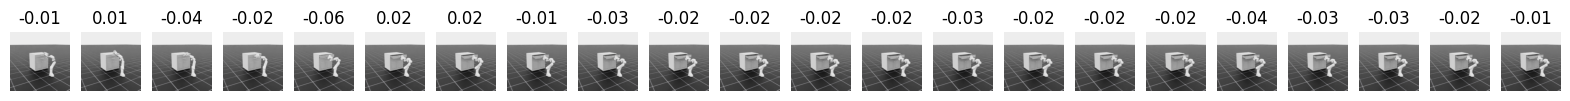

In [26]:
# Compute the idefics2 score for each of the franka cabinet videos
scores = []
for video_file in franca_cabinet_video_files[-1:]:
    video_frames = get_video_frames(video_path+video_file, num_frames=23, start_frame=5, end_frame=-1)
    caption = "the robot arm opens the top drawer of the white cabinet"
    base_caption = "a robot arm next to a white cabinet"
    _, scores, _, _ = compute_idefics2_baseline_score(video_frames, caption, base_caption, model, processor)
    
    print(f"Video: {video_file} - Score: {scores}")    
    # plot the frames with the score in the title on a single plot
    fig, axes = plt.subplots(1, len(video_frames)-1, figsize=(20, 10))
    for i, frame in enumerate(video_frames[1:]):
        axes[i].imshow(frame.numpy().astype(np.uint8))
        axes[i].set_title(f"{scores[i]:.2f}")
        axes[i].axis("off")

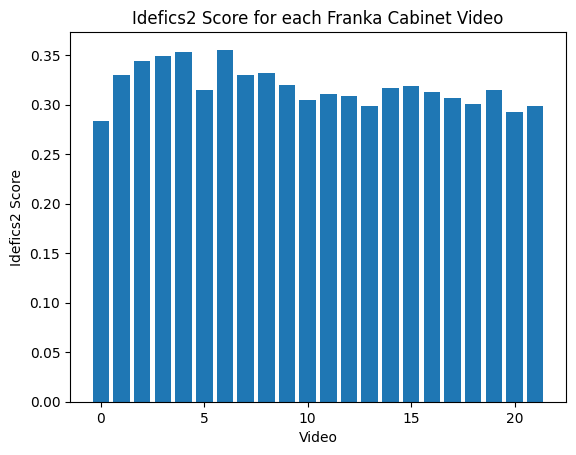

In [16]:
# Plot the scores with a bar chart
plt.bar(range(len(scores)), scores)
plt.xlabel("Video")
plt.ylabel("Idefics2 Score")
plt.title("Idefics2 Score for each Franka Cabinet Video")
plt.show()

The Idefics2 score for the video franka_cabinet_video_chpnt_4375000_timesteps_1.mp4 is 6942.0


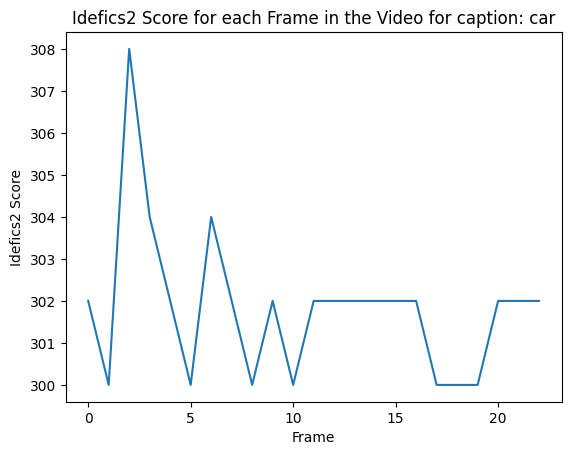

In [44]:
# Get the scores of the last video in the list
video_file = franca_cabinet_video_files[-1]
video_frames = get_video_frames(video_path+video_file, num_frames=23, start_frame=5, end_frame=-1)
caption = "car"
score, scores, image_embeddings, text_embeddings = compute_idefics2_score(video_frames, caption, model, processor)
print(f"The Idefics2 score for the video {video_file} is {score}")

# plot the scores for each frame
plt.plot(range(len(scores)), scores)
plt.xlabel("Frame")
plt.ylabel("Idefics2 Score")
plt.title(f"Idefics2 Score for each Frame in the Video for caption: {caption}")
plt.show()

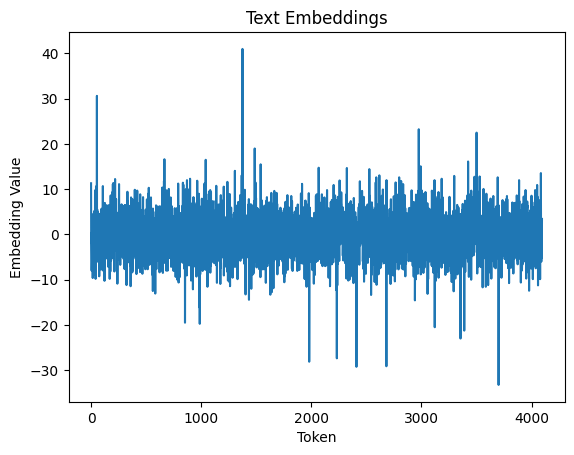

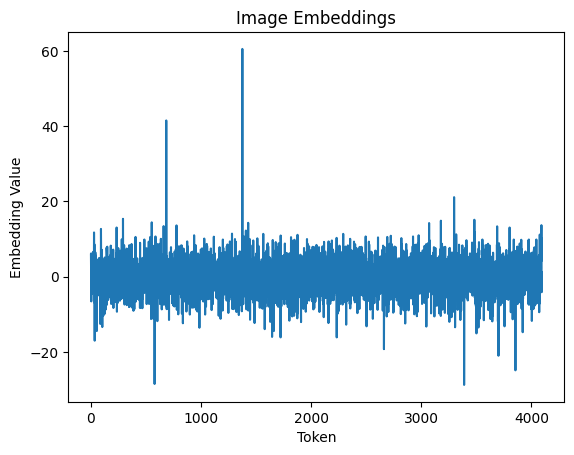

In [49]:
# plot the text and image embeddings
plt.figure()
plt.plot(range(len(text_embeddings[0])), text_embeddings[0].float().cpu().numpy())
plt.xlabel("Token")
plt.ylabel("Embedding Value")
plt.title("Text Embeddings")
plt.show()

plt.figure()
plt.plot(range(len(image_embeddings[0])), image_embeddings[0].float().cpu().numpy())
plt.xlabel("Token")
plt.ylabel("Embedding Value")
plt.title("Image Embeddings")
plt.show()


In [41]:
print(scores)

[296.0, 302.0, 294.0, 294.0, 296.0, 300.0, 302.0, 300.0, 302.0, 300.0, 300.0, 304.0, 302.0, 302.0, 302.0, 302.0, 302.0, 300.0, 298.0, 298.0, 300.0, 298.0, 300.0]


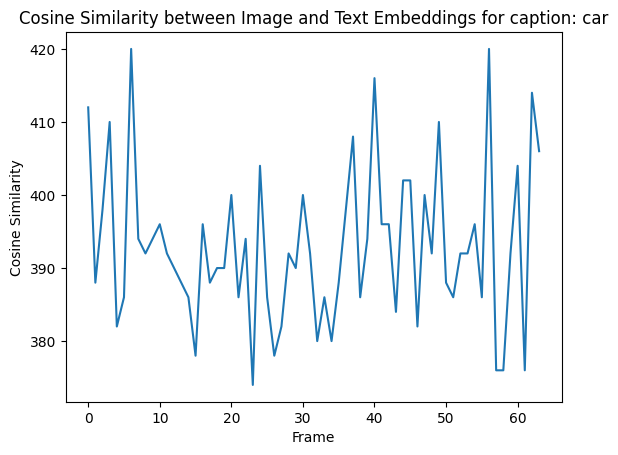

In [45]:
# compute the cosine similarity between the image and text embeddings
cos_sim = F.cosine_similarity(image_embeddings, text_embeddings)
sim = torch.exp(-F.pairwise_distance(image_embeddings, text_embeddings))
sim = F.pairwise_distance(image_embeddings, text_embeddings)
plt.plot(range(len(sim)), sim.float().cpu().numpy())
plt.xlabel("Frame")
plt.ylabel("Cosine Similarity")
plt.title(f"Cosine Similarity between Image and Text Embeddings for caption: {caption}")
plt.show()

In [46]:
F.pairwise_distance(image_embeddings, text_embeddings)

tensor([412., 388., 398., 410., 382., 386., 420., 394., 392., 394., 396., 392.,
        390., 388., 386., 378., 396., 388., 390., 390., 400., 386., 394., 374.,
        404., 386., 378., 382., 392., 390., 400., 392., 380., 386., 380., 388.,
        398., 408., 386., 394., 416., 396., 396., 384., 402., 402., 382., 400.,
        392., 410., 388., 386., 392., 392., 396., 386., 420., 376., 376., 392.,
        404., 376., 414., 406.], device='cuda:0', dtype=torch.bfloat16)

IndexError: index 23 is out of bounds for dimension 0 with size 23

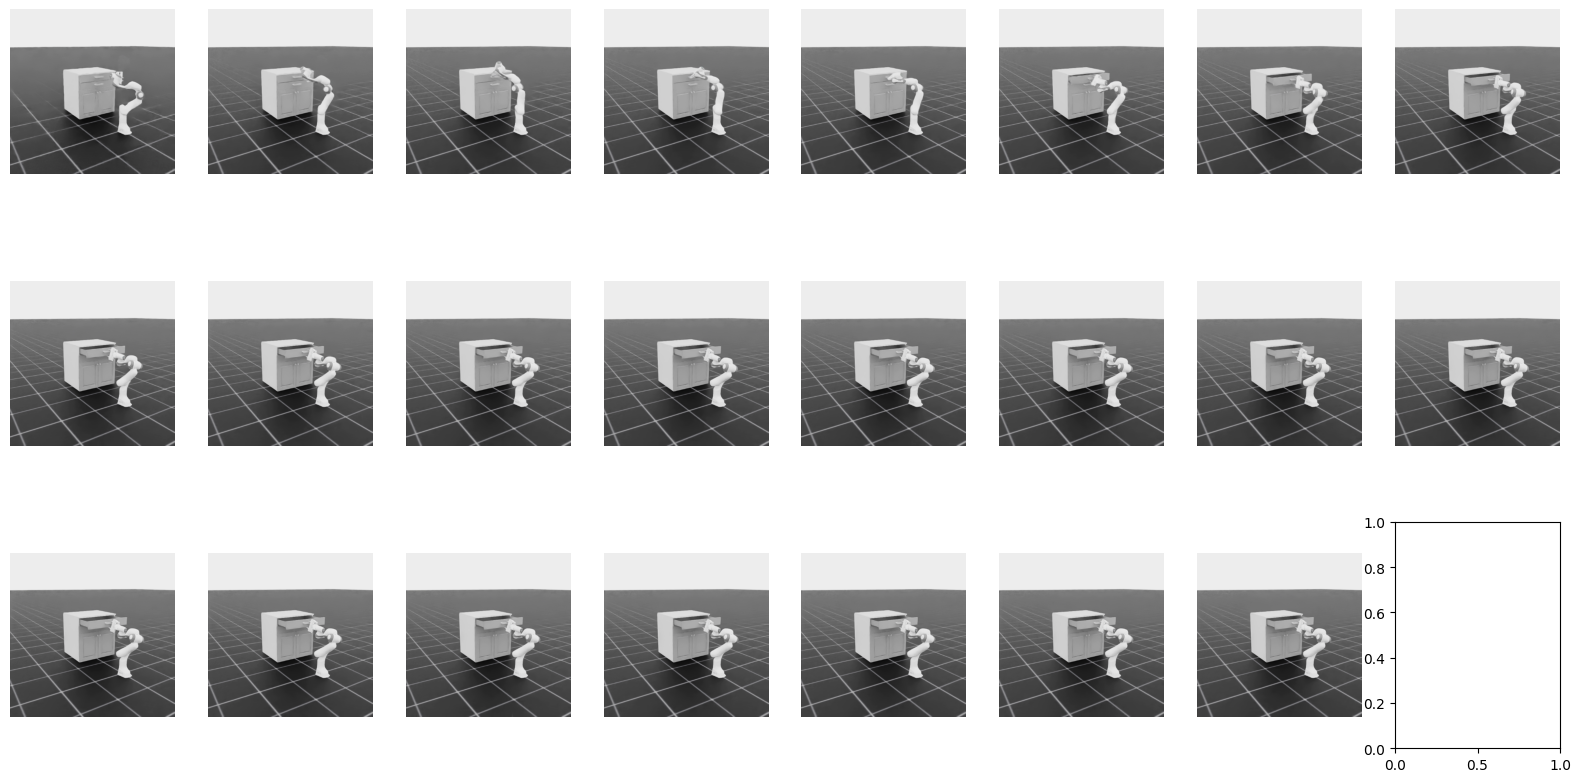

In [30]:
# Plot the frames of the video
fig, axs = plt.subplots(3, 8, figsize=(20, 10))
for i, ax in enumerate(axs.flat):
    ax.imshow(video_frames[i].numpy().astype(np.uint8))
    ax.axis("off")
plt.show()

## Run CLIP Tests

In [27]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")



config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

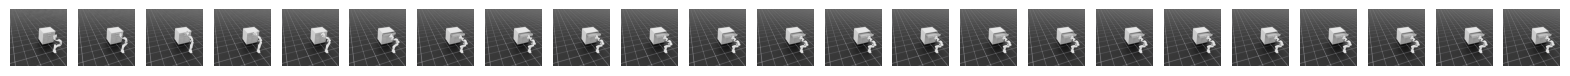

In [38]:
video_path = "/home/levi/data/dev_videos/franka_cabinet_896px_cam_high/"
# Get all the video files with the regex pattern
franca_cabinet_video_files = [f for f in os.listdir(video_path) if re.match(r'franka_cabinet_video.*\_1.mp4', f)]
# Sort the video files
franca_cabinet_video_files.sort()
video_frames = get_video_frames(video_path+video_file, num_frames=23, start_frame=5, end_frame=-1)


# plot the video frames in a single plot
fig, axes = plt.subplots(1, len(video_frames), figsize=(20, 10))
for i, frame in enumerate(video_frames):
    axes[i].imshow(frame.numpy().astype(np.uint8))
    axes[i].axis("off")
plt.show()

In [42]:
caption = "the robot arm opens the top drawer of the white cabinet"
caption = "the dog is running in the park"

inputs = processor(text=[caption], images=video_frames, return_tensors="pt", padding=True)
outputs = model(**inputs)

In [43]:
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

In [ ]:
outputs.

In [50]:
text_emb = outputs.text_embeds
image_emb = outputs.image_embeds

scores = F.cosine_similarity(text_emb, image_emb)
scores_np = scores.detach().cpu().numpy()
print(scores_np)

[0.20410846 0.17942356 0.19274548 0.18884215 0.18386108 0.18834455
 0.19064264 0.19110285 0.18865171 0.19360507 0.19199868 0.19409007
 0.19586828 0.19407088 0.19203308 0.19285904 0.19348286 0.19360492
 0.19349429 0.19381268 0.19266073 0.19299759 0.19218382]


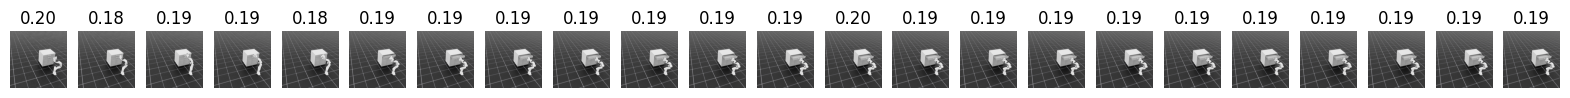

In [51]:
# plot the video frames on one plot
fig, axes = plt.subplots(1, len(video_frames), figsize=(20, 10))
for i, frame in enumerate(video_frames):
    axes[i].imshow(frame.numpy().astype(np.uint8))
    axes[i].set_title(f"{scores_np[i]:.2f}")
    axes[i].axis("off")
plt.show()

## GPT-4o experiments

In [3]:
from openai import OpenAI
import json
import base64
from PIL import Image
from io import BytesIO

# Set up your OpenAI API key
api_key = os.environ.get("OPENAIKEY")
client = OpenAI(
    api_key=api_key
)

# Helper function to encode image to base64
def encode_image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        # read in the file and resize to 480x480
        image = Image.open(image_file)
        image = image.resize((480, 480))
        # convert the image to base64
        buffered = BytesIO()
        image.save(buffered, format="PNG")
        return base64.b64encode(buffered.getvalue()).decode('utf-8')
        #return base64.b64encode(image_file.read().).decode('utf-8')




In [7]:
# List of image paths
image_paths = [
    "/home/levi/Pictures/Screenshot from franka_cabinet_video_chpnt_4375000_timesteps_1.mp4 - 2.png",
    # "/home/levi/Pictures/Screenshot from franka_cabinet_video_chpnt_4375000_timesteps_1.mp4 - 3.png",
    # "/home/levi/Pictures/Screenshot from franka_cabinet_video_chpnt_4375000_timesteps_1.mp4 - 4.png",
    "/home/levi/Pictures/Screenshot from franka_cabinet_video_chpnt_4375000_timesteps_1.mp4 - 5.png",
    # "/home/levi/Pictures/Screenshot from franka_cabinet_video_chpnt_4375000_timesteps_1.mp4 - 6.png",
    # "/home/levi/Pictures/Screenshot from franka_cabinet_video_chpnt_4375000_timesteps_1.mp4 - 7.png",
    "/home/levi/Pictures/Screenshot from franka_cabinet_video_chpnt_4375000_timesteps_1.mp4 - 8.png"
]

# Encode images to base64
encoded_images = [encode_image_to_base64(image_path) for image_path in image_paths]

# Construct the input for the model
prompt = """
A robot arm is given the manipulation task: "Grab the handle and pull open the top drawer of the white cabinet". The following images are observations of the robot actions. Provide a numerical assessment as to whether the robot has accomplished the task on a scale of 0 to 10. For the scale, 0 represents the task is not started and 10 represents the task is completed.

Here are the observations:
"""

for i, encoded_image in enumerate(encoded_images):
    prompt += f"Image {i+1}: ![image{i+1}](data:image/png;base64,{encoded_image})\n"




A robot arm is given the manipulation task: "Grab the handle and pull open the top drawer of the white cabinet". The following images are observations of the robot actions. Provide a numerical assessment as to whether the robot has accomplished the task on a scale of 0 to 10. For the scale, 0 represents the task is not started and 10 represents the task is completed.

Here are the observations:
Image 1: 
Image 2: 
Image 3: 


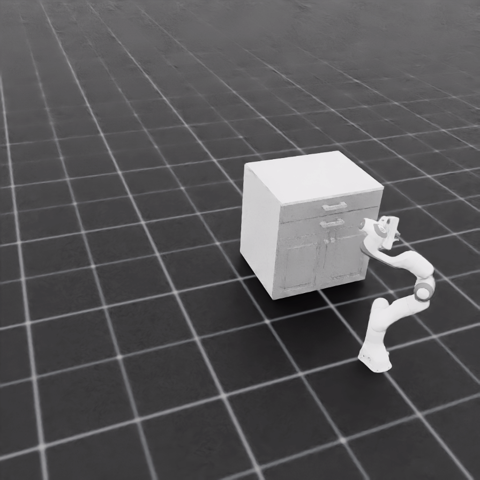
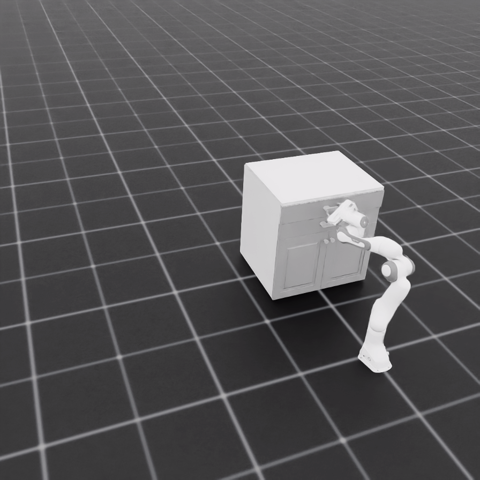
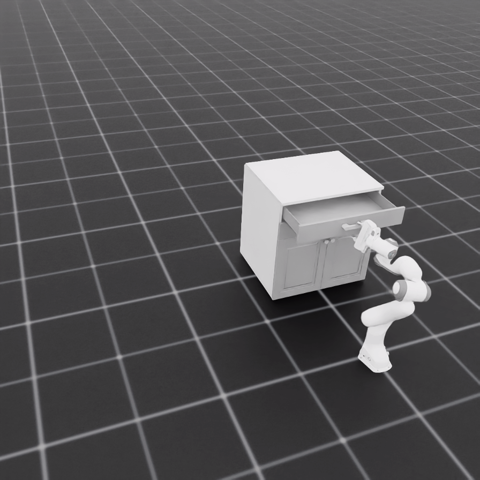

In [8]:
print(prompt)

In [9]:
# response = openai.chat.completions.create(
#     model="gpt-4o",
#     prompt=prompt,
#     max_tokens=300,
#     n=1,
#     stop=None,
#     temperature=0.5
# )

response = client.chat.completions.create(
  model="gpt-4o-mini",
  messages=[
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": "What are in these images? Is there any difference between them?",
        },
        {
          "type": "image_url",
          "image_url": {
            "url": "https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg/2560px-Gfp-wisconsin-madison-the-nature-boardwalk.jpg",
          },
        },
        {
          "type": "image_url",
          "image_url": {
            "url": "https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg/2560px-Gfp-wisconsin-madison-the-nature-boardwalk.jpg",
          },
        },
      ],
    }
  ],
  max_tokens=300,
)



RateLimitError: Error code: 429 - {'error': {'message': 'Request too large for gpt-4o in organization org-QQ63OYXhltjJ5LbLX7jWLzLL on tokens per min (TPM): Limit 30000, Requested 271555. The input or output tokens must be reduced in order to run successfully. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}

In [15]:
# Print the JSON result
print(chat_completion)

ChatCompletion(id='chatcmpl-9qjNCOh9SKB3oXruMUFaVErdU7wbT', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='This is a test.', role='assistant', function_call=None, tool_calls=None))], created=1722354498, model='gpt-4o-2024-05-13', object='chat.completion', service_tier=None, system_fingerprint='fp_4e2b2da518', usage=CompletionUsage(completion_tokens=5, prompt_tokens=12, total_tokens=17))
